# **1. PVWatts 100MW - Single Owner Example**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


**1.1   Model Initialization**

In [2]:
import PySAM.Pvwattsv7 as pv
import PySAM.Singleowner as so
system_model = pv.default('PVWattsSingleOwner')


**1.2   SystemDesign Group**

In [3]:
system_model.SystemDesign.system_capacity=100000 #kW
system_model.SystemDesign.module_type=1
system_model.SystemDesign.array_type=3
system_model.SystemDesign.tilt=0
system_model.SystemDesign.azimuth=0

**1.3   SolarResource Group**

In [4]:
system_model.SolarResource.solar_resource_file="Antofagasta.csv"

**1.4.   Outputs Group**

In [5]:
system_model.execute()
gen_pv=np.array(system_model.Outputs.dc)/1000
month_pv=system_model.Outputs.dc_monthly

In [6]:
%store gen_pv
%store month_pv

Stored 'gen_pv' (ndarray)
Stored 'month_pv' (tuple)


**CF - PV**

In [7]:
system_model.Outputs.capacity_factor

28.966386556904826

In [8]:
gen_pv_limit=np.array(gen_pv)
for i in range(0,8760):
  if (gen_pv_limit[i]<100000*0.1):
    gen_pv_limit[i]=0

**CF - ALK - PV**

In [9]:
CF_pv_alk=sum(gen_pv_limit)/(100000*8760)
CF_pv_alk

0.3007837064018366

**CF - PEM - PV**

In [10]:
CF_pv_PEM=sum(gen_pv)/(100000*8760)
CF_pv_PEM

0.30184630409612756

# <center> $LCOE=\frac{\sum_{i=0}^{N}\frac{CAPEX_i}{\left(1+t\right)^i}+\sum_{i=1}^{N}\frac{OPEX_i}{\left(1+t\right)^i}}{\sum_{i=1}^{N}\frac{Production_i}{\left(1+t\right)^i}}$ <center>

In [11]:
def LCOE_pv(d,Module,Balance,Land_prep,Installation_labor,Contingency,percent_opex):
    Sum1=0
    Sum2=0
    t=0.07
    for i in range(1,31):
        Sum1 = Sum1 + (((1-d)**i)/((1+t)**i))
        Sum2 = Sum2 + (1/((1+t)**i))
    Production_pv=sum(gen_pv)
    CAPEX= ((Module + Installation_labor+Balance)*Contingency + Land_prep)*system_model.SystemDesign.system_capacity*1000
    OPEX=percent_opex*CAPEX
    LCOE_pv=((CAPEX+OPEX*Sum2)/(Production_pv*Sum1))*1000
    return LCOE_pv

**LCOE 2021**

In [12]:
LCOE_pv_2021=LCOE_pv(0.7/100,0.41,0.2,0.02,0.11,101/100,2/100) #USD/MWh
%store LCOE_pv_2021
LCOE_pv_2021

Stored 'LCOE_pv_2021' (float64)


30.607326460784936

**LCOE 2030**

In [13]:
LCOE_pv_2030=LCOE_pv(0.5/100,0.17,0.1,0.01,0.11,101/100,1/100) #USD/MWh
%store LCOE_pv_2030
LCOE_pv_2030

Stored 'LCOE_pv_2030' (float64)


14.22703412243445

# ${LCOH}_2=P_{inst}\bullet I\bullet\frac{FRC+M\left(f_p\right)}{h{\bullet f}_p\bullet Q_{H_2}}+Q_{H_2O}{\bullet P}_{H_2O}+Q_e\bullet P_e-Q_{O_2}\bullet P_{O_2}$


In [14]:
def LCOH(I,LCOE,f_p,eff,stack_lifetime=90000,percent_remp=0.4):
    P_inst=100 #Installed power of the electrolyser [MW]
    i=0.07
    h=8760 #Hours in a year
    N_rep=stack_lifetime/(f_p*h)
    I=I+I*percent_remp*(1-i)**N_rep
    n=30
    FRC=(i*((1+i)**n))/(((1+i)**n)-1)  #Capital Recovery Factor
    M=0.017 #Maintenance cost function as a percentage of investment, dependent on plant factor
    Q_h2=20.3 #Hydrogen production capacity [kg/h]
    Q_H2O=0.017  #Amount of water consumed [m3/kg of hydrogen]
    P_H2O=1.4 #Water price [USD/m3]
    Q_e=33.3/eff  #Amount of electricity consumed [kWh/kg of hydrogen] 
    P_e=LCOE
    Q_O2=7.8 #Sale of oxygen taking into account the quantity produced [kgO2/kg of hydrogen] (optional term)
    P_O2=0.03 #Selling price of oxygen [USD/kgO2] (optional term)
    #LCOH_2 = P_inst*I*((FRC+M)/(h*f_p*Q_h2))+Q_H2O*P_H2O+Q_e*P_e-Q_O2*P_O2
    LCOH = I*(FRC+M)*33.3/(h*f_p*eff)+Q_H2O*P_H2O+Q_e*P_e
    Water=Q_H2O*P_H2O
    Electricity=Q_e*P_e
    Electrolysis=I*(FRC+M)*33.3/(h*f_p*eff)
    
    return(LCOH,Water,Electricity,Electrolysis)


**LCOH - PV - ALK - 2021**

In [15]:
LCOH_pv_alk_2021=LCOH(500,LCOE_pv_2021/1000,CF_pv_alk,0.63,100000)[0]
LCOH_pv_alk_2021

2.645363357286994


**LCOH - PV - PEM - 2021**

In [16]:
LCOH_pv_PEM_2021=LCOH(1100,LCOE_pv_2021/1000,CF_pv_PEM,0.56)[0]
LCOH_pv_PEM_2021

4.339573153913777

**LCOH - PV - ALK - 2030**

In [17]:
LCOH_pv_alk_2030=LCOH(400,LCOE_pv_2030/1000,CF_pv_alk,0.65,100000,0.15)[0]
LCOH_pv_alk_2030

1.5188739453168738

**LCOH - PV - PEM - 2030**

In [18]:
LCOH_pv_PEM_2030=LCOH(650,LCOE_pv_2030/1000,CF_pv_PEM,0.63,percent_remp=0.2)[0]
LCOH_pv_PEM_2030

2.065240520724514

Text(0, 0.5, 'USD/kg')

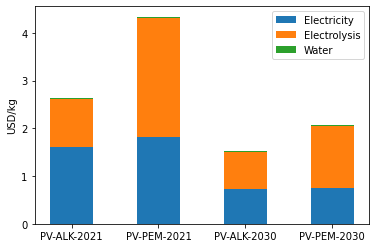

In [19]:
labels = ['PV-ALK-2021',"PV-PEM-2021","PV-ALK-2030","PV-PEM-2030"]
W = [LCOH(500,LCOE_pv_2021/1000,CF_pv_alk,0.63,100000)[1],LCOH(1100,LCOE_pv_2021/1000,CF_pv_PEM,0.56)[1],LCOH(400,LCOE_pv_2030/1000,CF_pv_alk,0.65,100000,0.15)[1],LCOH(650,LCOE_pv_2030/1000,CF_pv_PEM,0.63,percent_remp=0.2)[1]]
Electri = [LCOH(500,LCOE_pv_2021/1000,CF_pv_alk,0.63,100000)[2],LCOH(1100,LCOE_pv_2021/1000,CF_pv_PEM,0.56)[2],LCOH(400,LCOE_pv_2030/1000,CF_pv_alk,0.65,100000,0.15)[2],LCOH(650,LCOE_pv_2030/1000,CF_pv_PEM,0.63,percent_remp=0.2)[2]]
Electro = [LCOH(500,LCOE_pv_2021/1000,CF_pv_alk,0.63,100000)[3],LCOH(1100,LCOE_pv_2021/1000,CF_pv_PEM,0.56)[3],LCOH(400,LCOE_pv_2030/1000,CF_pv_alk,0.65,100000,0.15)[3],LCOH(650,LCOE_pv_2030/1000,CF_pv_PEM,0.63,percent_remp=0.2)[3]]
width = 0.5       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

bars = np.add(Electri, Electro).tolist()

ax.bar(labels, Electri, width, label='Electricity')
ax.bar(labels, Electro, width, bottom=Electri,label='Electrolysis')
ax.bar(labels, W, width, bottom=bars,label='Water')
ax.legend()

ax.set_ylabel("USD/kg")
#ax.set_title('Levelised Cost of Hydrogen - PV')

#ax.bar(labels, women_means, width, bottom=men_means,label='Women')

#Agua=W*100/(W+Electri+Electro)


In [20]:
i=3
Agua=W[i]*100/(W[i]+Electri[i]+Electro[i])
Agua

1.1524081462265057

In [21]:
Electricidad=Electri[i]*100/(W[i]+Electri[i]+Electro[i])
Electricidad

36.41224193970163

In [22]:
Electrolizador=Electro[i]*100/(W[i]+Electri[i]+Electro[i])
Electrolizador

62.435349914071864

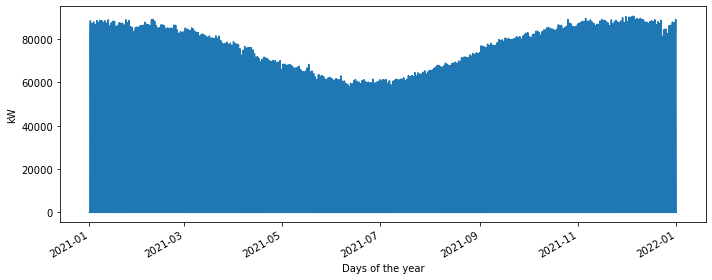

In [23]:
fig, ax = plt.subplots(figsize=(10, 4), tight_layout=True, facecolor='w')
ax.plot(pd.date_range(start='1/1/2021', end='01/01/2022',periods=8760),gen_pv)
ax.set_ylabel('kW')
ax.set_xlabel('Days of the year')
fig.autofmt_xdate()

In [24]:
LHV=33.3 #(kWh/KgH2)
eff_PEM=0.56
eff_ALK=0.63
df1=pd.DataFrame(np.array(system_model.Outputs.dc_monthly))
df1["PEM"]=(df1[0]/(LHV/eff_PEM + 6.4))*(LHV/eff_PEM)
df1["Liq"]=(df1[0]/(LHV/eff_PEM + 6.4))*6.4
df1["Alk"]=(df1[0]/(LHV/eff_ALK + 6.4))*(LHV/eff_ALK)
df1["Liq1"]=(df1[0]/(LHV/eff_ALK + 6.4))*6.4
df1["PEM1"]=(df1[0]/(LHV/eff_PEM + 1.05))*(LHV/eff_PEM)
df1["Comp"]=(df1[0]/(LHV/eff_PEM + 1.05))*1.05
df1["Alk1"]=(df1[0]/(LHV/eff_ALK + 1.05))*(LHV/eff_ALK)
df1["Comp1"]=(df1[0]/(LHV/eff_ALK + 1.05))*1.05

Months=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sept","Oct","Nov","Dec"]
df1.index=Months
df1.columns=["Energy", "PEM","Liq","Alk","Liq1","PEM1","Comp","Alk1","Comp1"]

<ipython-input-25-53dd97686e57>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0, 0].set_xticklabels(Months)
<ipython-input-25-53dd97686e57>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0, 1].set_xticklabels(Months)
<ipython-input-25-53dd97686e57>:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1, 0].set_xticklabels(Months)
<ipython-input-25-53dd97686e57>:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1, 1].set_xticklabels(Months)


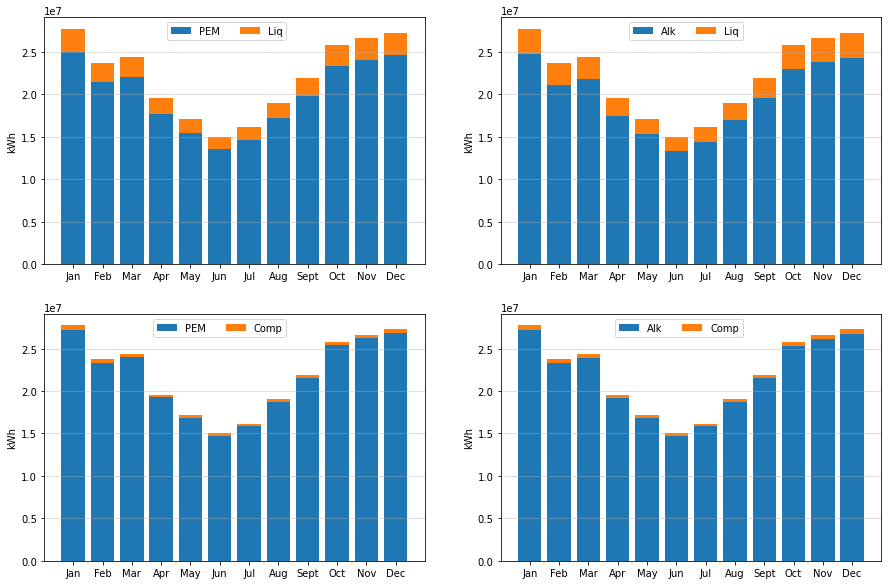

In [25]:
x=range(12)
fig, ax = plt.subplots(2, 2,constrained_layout=False)
fig.set_size_inches(15, 10)

ax[0, 0].bar(x=range(12), 
       height=df1["PEM"],
       label='PEM',
       width=0.8, bottom=0, align='center', 
       color=None, edgecolor=None, linewidth=None); 
ax[0, 0].bar(x=range(12), 
       height=df1["Liq"],
       bottom=df1["PEM"],
       label='Liq',
       #width=0.8, bottom=0, align='center',
        color=None, edgecolor=None, linewidth=None); 
ax[0, 0].set_ylabel('kWh')
#ax[0, 0].set_xlabel('Months')
#ax[0, 0].set_title('Monthly system power generated')
ax[0, 0].legend(loc=1, ncol=3, bbox_to_anchor=(0.65, 1))
ax[0, 0].set_xticklabels(Months)
ax[0, 0].set_xticks(range(12))
ax[0, 0].grid(alpha=0.5,axis='y')


ax[0, 1].bar(x=range(12), 
       height=df1["Alk"],
       label='Alk',
       width=0.8, bottom=0, align='center',
       color=None, edgecolor=None, linewidth=None); 
ax[0, 1].bar(x=range(12), 
       height=df1["Liq1"],
       bottom=df1["Alk"],
       label='Liq',
       #width=0.8, bottom=0, align='center', 
       color=None, edgecolor=None, linewidth=None); 
ax[0, 1].set_ylabel('kWh')
#ax[0, 1].set_xlabel('Months')
#ax[0, 1].set_title('Monthly system power generated')
ax[0, 1].legend(loc=1, ncol=3, bbox_to_anchor=(0.65, 1))
ax[0, 1].set_xticklabels(Months)
ax[0, 1].set_xticks(x)
ax[0, 1].grid(alpha=0.5,axis='y')


ax[1, 0].bar(x=range(12), 
       height=df1["PEM1"],
       label='PEM',
       width=0.8, bottom=0, align='center', 
       color=None, edgecolor=None, linewidth=None); 
ax[1, 0].bar(x=range(12), 
       height=df1["Comp"],
       bottom=df1["PEM1"],
       label='Comp',
       #width=0.8, bottom=0, align='center', 
       color=None, edgecolor=None, linewidth=None); 
ax[1, 0].set_ylabel('kWh')
#ax[1, 0].set_xlabel('Months')
#ax[1, 0].set_title('Monthly system power generated')
ax[1, 0].legend(loc=1, ncol=3, bbox_to_anchor=(0.65, 1))
ax[1, 0].set_xticklabels(Months)
ax[1, 0].set_xticks(x)
ax[1, 0].grid(alpha=0.5,axis='y')


ax[1, 1].bar(x=range(12), 
       height=df1["Alk1"],
       label='Alk',
       width=0.8, bottom=0, align='center', 
       color=None, edgecolor=None, linewidth=None); 
ax[1, 1].bar(x=range(12), 
       height=df1["Comp1"],
       bottom=df1["Alk1"],
       label='Comp',
       #width=0.8, bottom=0, align='center', 
       color=None, edgecolor=None, linewidth=None); 
ax[1, 1].set_ylabel('kWh')
#ax[1, 1].set_xlabel('Months')
#ax[1, 1].set_title('Monthly system power generated')
ax[1, 1].legend(loc=1, ncol=3, bbox_to_anchor=(0.65, 1))
ax[1, 1].set_xticklabels(Months)
ax[1, 1].set_xticks(x)
ax[1, 1].grid(alpha=0.5,axis='y')


In [26]:
#2021
LHV=33.3 #(kWh/KgH2)
eff_PEM=0.56
eff_ALK=0.63
H2_PEM_Liq=(np.array(system_model.Outputs.dc_monthly)/(LHV/eff_PEM+6.4))*(1/1000)
H2_PEM_Comp=(np.array(system_model.Outputs.dc_monthly)/(LHV/eff_PEM+1.05))*(1/1000)
H2_Alk_Liq=(np.array(system_model.Outputs.dc_monthly)/(LHV/eff_ALK+6.4))*(1/1000)
H2_Alk_Comp=(np.array(system_model.Outputs.dc_monthly)/(LHV/eff_ALK+1.05))*(1/1000)

<ipython-input-27-4a06a772082f>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(Months)


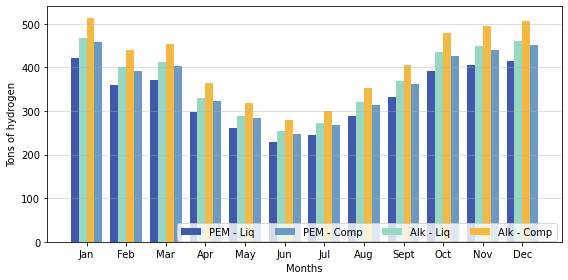

In [27]:
fig, ax = plt.subplots(figsize=(8, 4), tight_layout=True, facecolor='w')
y=np.arange(12)
width1 = 0.2
ax.bar(y - 1.5*width1, 
       height=H2_PEM_Liq,
       label="PEM - Liq",
       width=0.2, color="#4059AD"); 

ax.bar(y +1.5*width1, 
       height=H2_PEM_Comp,
       label='PEM - Comp',
       width=0.2,color="#6B9AC4"); 

ax.bar(y-0.5*width1, 
       height=H2_Alk_Liq,
       label='Alk - Liq',
       width=0.2,color="#97D8C4"); 

ax.bar(y + 0.5*width1,
       height=H2_Alk_Comp,
       label='Alk - Comp',
       width=0.2, color="#F4B942"); 
       
ax.set_ylabel('Tons of hydrogen')
ax.set_xlabel('Months')
#ax.set_title('Monthly Hydrogen Production 2021')
ax.legend(loc=1, ncol=4, bbox_to_anchor=(1, 0.1))
ax.set_xticklabels(Months)
ax.set_xticks(y)
ax.grid(alpha=0.5,axis='y')

In [28]:
#2030
LHV=33.3 #(kWh/KgH2)
eff_PEM=0.63
eff_ALK=0.65
H2_PEM_Liq=(np.array(system_model.Outputs.dc_monthly)/(LHV/eff_PEM+6.4))*(1/1000)
H2_PEM_Comp=(np.array(system_model.Outputs.dc_monthly)/(LHV/eff_PEM+1.05))*(1/1000)
H2_Alk_Liq=(np.array(system_model.Outputs.dc_monthly)/(LHV/eff_ALK+6.4))*(1/1000)
H2_Alk_Comp=(np.array(system_model.Outputs.dc_monthly)/(LHV/eff_ALK+1.05))*(1/1000)

<ipython-input-29-482f7f086ee5>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(Months)


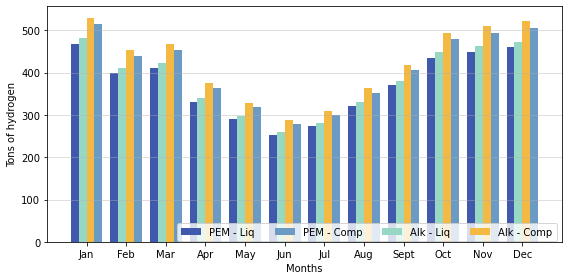

In [29]:
fig, ax = plt.subplots(figsize=(8, 4), tight_layout=True, facecolor='w')
y=np.arange(12)
width1 = 0.2
ax.bar(y - 1.5*width1,
       height=H2_PEM_Liq,
       label="PEM - Liq",
       width=0.2,color="#4059AD"); 

ax.bar(y +1.5*width1,
       height=H2_PEM_Comp,
       label='PEM - Comp',
       width=0.2,color="#6B9AC4"); 

ax.bar(y-0.5*width1, 
       height=H2_Alk_Liq,
       label='Alk - Liq',
       width=0.2,color="#97D8C4"); 

ax.bar(y + 0.5*width1,
       height=H2_Alk_Comp,
       label='Alk - Comp',
       width=0.2,color="#F4B942"); 
       
ax.set_ylabel('Tons of hydrogen')
ax.set_xlabel('Months')
#ax.set_title('Monthly Hydrogen Production 2030')
ax.legend(loc=1, ncol=4, bbox_to_anchor=(1, 0.1))
ax.set_xticklabels(Months)
ax.set_xticks(y)
ax.grid(alpha=0.5,axis='y')

In [30]:
day_prod=(sum(gen_pv)/365)*0.63/33.3

In [31]:
day_prod

13705.453807607955

In [32]:
flow_max=gen_pv.max()*0.63/33.3

In [33]:
flow_max

1713.1684951308973

In [34]:
#Compressed hydrogen gas storage system

i=0.07
n_conversion=15
n_storage=20

FRC_conversion=(i*((1+i)**n_conversion))/(((1+i)**n_conversion)-1)
FRC_storage=(i*((1+i)**n_storage))/(((1+i)**n_storage)-1)

M_storage=2/100
M_conversion=4/100

storage_module=500*day_prod*((FRC_storage+M_storage)/(sum(gen_pv_limit)*0.63/33.3))  #USD
conversion_module=3900*flow_max*1.05*((FRC_conversion+M_conversion)/(sum(gen_pv_limit)*0.63/33.3))

GH2=storage_module+conversion_module

In [35]:
GH2  #USD/kg

0.3680683077179385

In [36]:
#Liquid hydrogen

i=0.07
n_conversion=20
n_storage=20

FRC_conversion=(i*((1+i)**n_conversion))/(((1+i)**n_conversion)-1)
FRC_storage=(i*((1+i)**n_storage))/(((1+i)**n_storage)-1)

M_storage=2/100
M_conversion=8/100


storage_module=90*day_prod*((FRC_storage+M_storage)/(sum(gen_pv_limit)*0.63/33.3))  #USD
conversion_module=50000*flow_max*((FRC_conversion+M_conversion)/(sum(gen_pv_limit)*0.63/33.3))
LH2=storage_module+conversion_module

In [37]:
LH2

3.025012681864771

In [38]:
LCOH_pv_PPA_2021=LCOH(500,54.7/1000,0.42,0.63,100000)[0]
LCOH_pv_PPA_2021

3.6550790628069936

In [39]:
LCOH_pv_PPA_2030=LCOH(400,38.7/1000,0.42,0.65,100000,0.15)[0]
LCOH_pv_PPA_2030

2.561306869385997